## Autoencoders

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transform: convert images to tensors and normalize to [0, 1]
transform = transforms.ToTensor()

# Download and load the training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Show dataset info
print("Training set size:", len(train_dataset))
print("Test set size:", len(test_dataset))

# Show one example
images, labels = next(iter(train_loader))
print("Image shape:", images[0].shape)
print("Label:", labels[0])

Training set size: 60000
Test set size: 10000
Image shape: torch.Size([1, 28, 28])
Label: tensor(2)


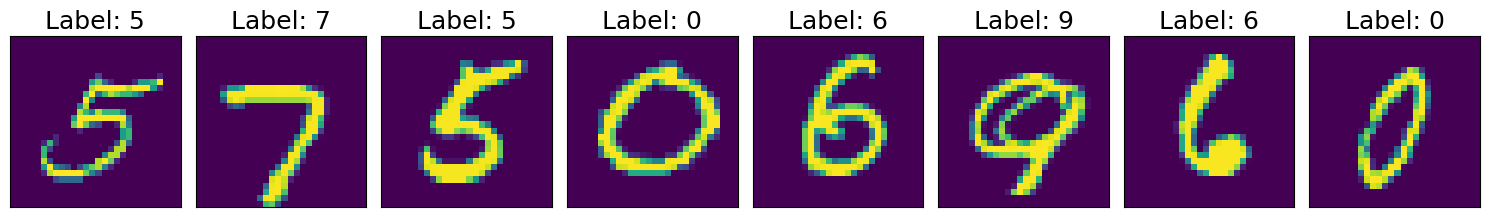

In [2]:
import matplotlib.pyplot as plt

# Get one batch
images, labels = next(iter(train_loader))

# Plot 8 images (1 rows, 8 columns)
fig, axs = plt.subplots(1, 8, figsize=(15, 4))
axs = axs.flatten()

for i in range(8):
    img = images[i].squeeze(0)  # shape: [1, 28, 28] → [28, 28]
    label = labels[i].item()
    
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {label}", fontsize=18)
    axs[i].tick_params(axis='both', labelsize=16)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()

## Define the model

In [3]:
import torch.nn as nn

class Encoder(nn.Module):
    """
    Encoder network that compresses 28x28 MNIST images into a lower-dimensional latent space
    """
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=2):
        """
        Initialize the encoder network
        
        Args:
            input_dim (int): Input dimension (784 for flattened 28x28 images)
            hidden_dim (int): Hidden layer dimension
            latent_dim (int): Latent space dimension (bottleneck)
        """
        super(Encoder, self).__init__()
        
        # Define the encoder layers
        self.encoder = nn.Sequential(
            # First layer: input to hidden
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),  # ReLU activation for non-linearity
            
            # Second layer: hidden to smaller hidden
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            
            # Third layer: compress to latent space (bottleneck)
            nn.Linear(hidden_dim // 2, latent_dim)
        )
    
    def forward(self, x):
        """
        Forward pass through the encoder
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 784)
            
        Returns:
            torch.Tensor: Encoded representation of shape (batch_size, latent_dim)
        """
        # Flatten the input if it's not already flattened
        x = x.view(x.size(0), -1)
        
        # Pass through encoder layers
        encoded = self.encoder(x)
        return encoded

class Decoder(nn.Module):
    """
    Decoder network that reconstructs images from the latent space representation
    """
    def __init__(self, latent_dim=64, hidden_dim=128, output_dim=784):
        """
        Initialize the decoder network
        
        Args:
            latent_dim (int): Latent space dimension (input to decoder)
            hidden_dim (int): Hidden layer dimension
            output_dim (int): Output dimension (784 for flattened 28x28 images)
        """
        super(Decoder, self).__init__()
        
        # Define the decoder layers (mirror of encoder)
        self.decoder = nn.Sequential(
            # First layer: latent to hidden
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            
            # Second layer: expand hidden dimension
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            
            # Third layer: hidden to output
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()  # Sigmoid to ensure output is in [0, 1] range
        )
    
    def forward(self, x):
        """
        Forward pass through the decoder
        
        Args:
            x (torch.Tensor): Latent representation of shape (batch_size, latent_dim)
            
        Returns:
            torch.Tensor: Reconstructed image of shape (batch_size, 784)
        """
        # Pass through decoder layers
        decoded = self.decoder(x)
        return decoded

class Autoencoder(nn.Module):
    """
    Complete autoencoder that combines encoder and decoder
    """
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=2):
        """
        Initialize the autoencoder
        
        Args:
            input_dim (int): Input dimension
            hidden_dim (int): Hidden layer dimension
            latent_dim (int): Latent space dimension
        """
        super(Autoencoder, self).__init__()
        
        # Initialize encoder and decoder modules
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
    
    def forward(self, x):
        """
        Forward pass through the complete autoencoder
        
        Args:
            x (torch.Tensor): Input images
            
        Returns:
            torch.Tensor: Reconstructed images
        """
        # Encode the input
        latent = self.encoder(x)
        
        # Decode the latent representation
        reconstructed = self.decoder(latent)
        
        return reconstructed
    
    def encode(self, x):
        """
        Encode input to latent space
        
        Args:
            x (torch.Tensor): Input images
            
        Returns:
            torch.Tensor: Latent representations
        """
        return self.encoder(x)
    
    def decode(self, z):
        """
        Decode latent representations to images
        
        Args:
            z (torch.Tensor): Latent representations
            
        Returns:
            torch.Tensor: Reconstructed images
        """
        return self.decoder(z)

## Training

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------------------------------------
# 1. Load MNIST dataset (with ToTensor transform)
# -----------------------------------------------------
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# -----------------------------------------------------
# 2. Choose device
# -----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------------------------------
# 3. Define CNN model using nn.Sequential
# -----------------------------------------------------
model = Autoencoder().to(device)

# -----------------------------------------------------
# 4. Define loss and optimizer
# -----------------------------------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------------------------------
# 5. Training loop
# -----------------------------------------------------
epochs = 10
loss_vals = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)

        outputs = model(images)               # Forward pass
        # Flatten images for loss calculation
        images_flat = images.view(images.size(0), -1)        
        loss = criterion(outputs, images_flat)     # Compute loss

        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_vals.append(avg_loss)

    print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f}")

Using device: cuda
Epoch  1 | Loss: 0.0582
Epoch  2 | Loss: 0.0468
Epoch  3 | Loss: 0.0441
Epoch  4 | Loss: 0.0426
Epoch  5 | Loss: 0.0416
Epoch  6 | Loss: 0.0409
Epoch  7 | Loss: 0.0402
Epoch  8 | Loss: 0.0397
Epoch  9 | Loss: 0.0393
Epoch 10 | Loss: 0.0390


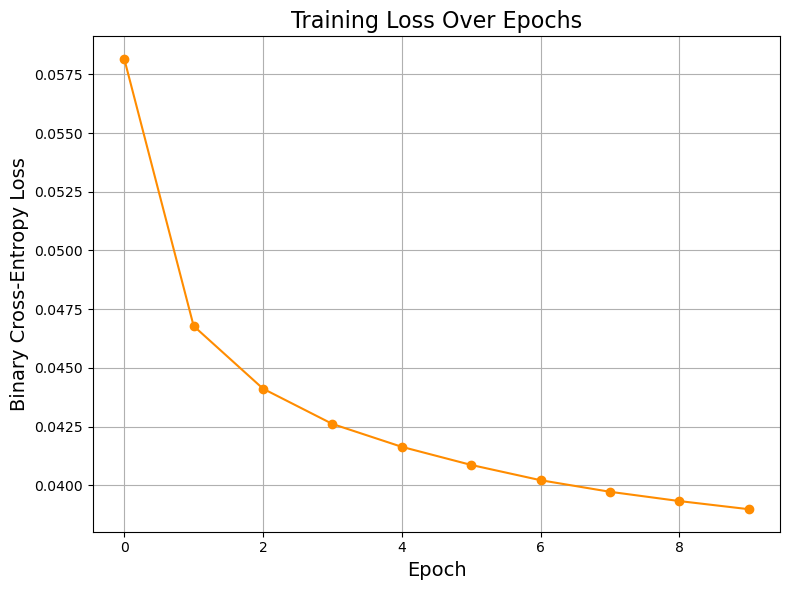

In [46]:
# ---------------------------------------
# 6. Visualize the loss curve
# ---------------------------------------
plt.figure(figsize=(8, 6))
plt.plot(loss_vals, 'o-', color='darkorange')
plt.title("Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Binary Cross-Entropy Loss", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

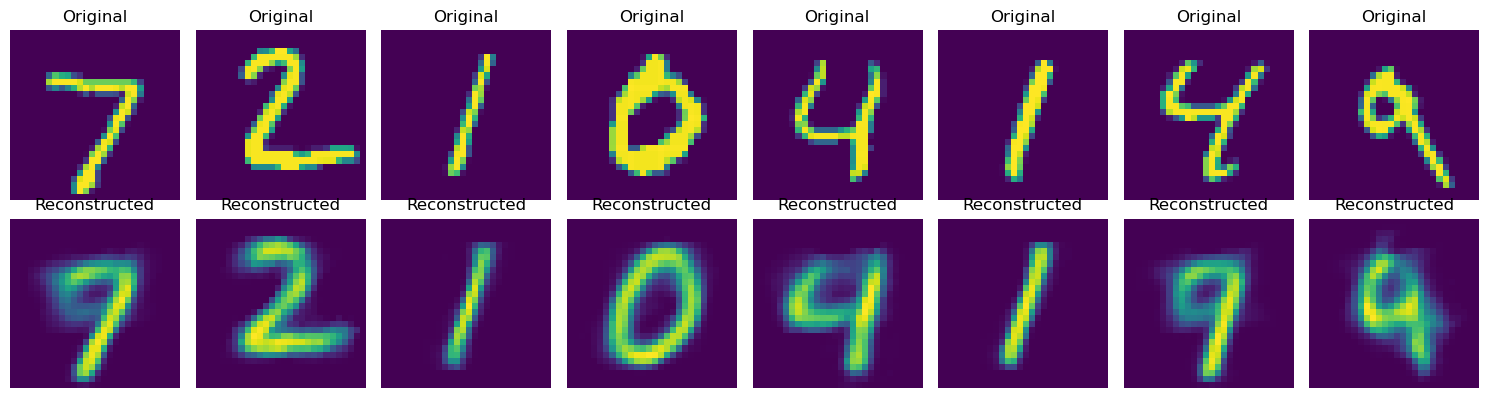

In [47]:
def visualize_reconstructions(model, test_loader, num_images=8):
    """
    Visualize original and reconstructed images
    
    Args:
        model (nn.Module): Trained autoencoder model
        test_loader (DataLoader): Test data loader
        num_images (int): Number of images to visualize
    """
    model.eval()  # Set model to evaluation mode
    
    # Get a batch of test data
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        
        # Get reconstructions
        reconstructed = model(data)
        
        # Move data back to CPU for visualization
        data = data.cpu()
        reconstructed = reconstructed.cpu()
        
        # Create subplots
        fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].squeeze())
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Reconstructed images
            reconstructed_img = reconstructed[i].view(28, 28)
            axes[1, i].imshow(reconstructed_img)
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
visualize_reconstructions(model=model, test_loader=test_loader)

## Visualize Latent Space

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def encode_batch(encoder, dataset_to_encode, batch_size=128):
    """
    Encode an entire dataset using the provided encoder network
    
    Args:
        encoder: PyTorch network (nn.Module) that takes in a dataset and converts it to a new dimension
        dataset_to_encode: PyTorch Dataset object that we want to encode
        batch_size (int): Batch size for processing (default: 128)
    
    Returns:
        tuple: (projected, labels) where:
            - projected: numpy array of encoded/projected data
            - labels: numpy array of original labels from the dataset
    """
    # Create lists to store the results
    projected = []
    labels = []
    
    # Switch encoder to evaluation mode (disables dropout, batch norm updates, etc.)
    encoder.eval()
    
    # Move encoder to CPU for simplicity (you can keep on GPU if preferred)
    encoder = encoder.cpu()
    
    print(f"Encoding dataset with {len(dataset_to_encode)} samples...")
    
    # Disable gradient computation for efficiency during inference
    with torch.no_grad():
        # Create DataLoader to process dataset in batches
        data_loader = DataLoader(dataset_to_encode, batch_size=batch_size, shuffle=False)
        
        # Process each batch
        for batch_idx, (x, y) in enumerate(data_loader):
            # Move data to CPU (matches encoder device)
            x = x.cpu()
            y = y.cpu()
            
            # Encode the original data
            z = encoder(x)
            
            # Store the encoded version and labels as numpy arrays
            projected.append(z.numpy())  # Convert tensor to numpy
            labels.append(y.numpy().ravel())  # Flatten labels and convert to numpy
            
            # Print progress every 50 batches
            if batch_idx % 50 == 0:
                print(f"Processed batch {batch_idx}/{len(data_loader)}")
    
    # Combine all batches into single large numpy arrays
    projected = np.vstack(projected)  # Stack vertically (concatenate along first dimension)
    labels = np.hstack(labels)        # Stack horizontally (concatenate into 1D array)
    
    print(f"Encoding complete! Shape: {projected.shape}, Labels: {labels.shape}")
    
    # Return the results
    return projected, labels

In [50]:
z, y = encode_batch(encoder=model.encoder, dataset_to_encode=test_dataset)

Encoding dataset with 10000 samples...
Processed batch 0/79
Processed batch 50/79
Encoding complete! Shape: (10000, 2), Labels: (10000,)


Text(0, 0.5, 'Latent Space Dim 2')

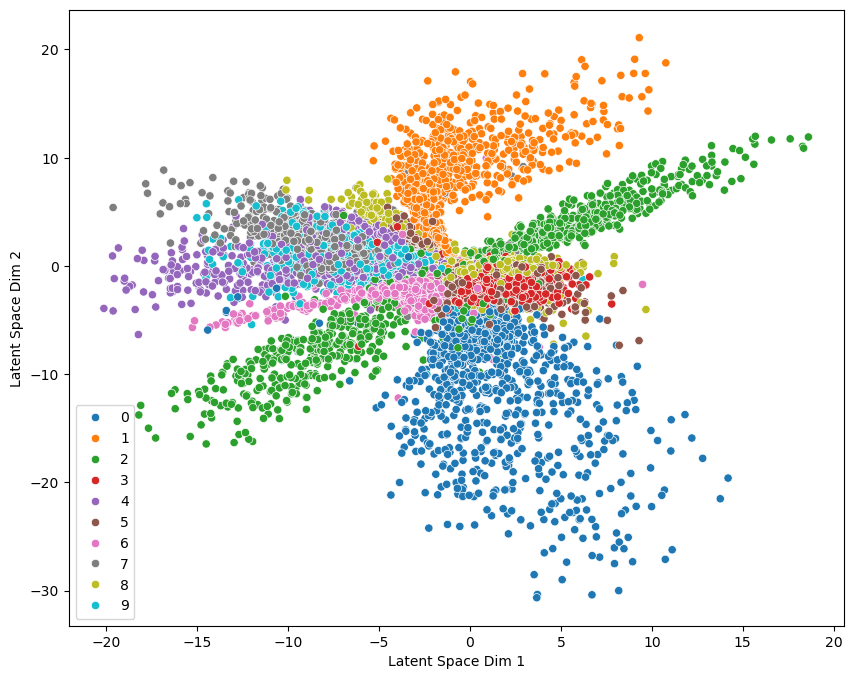

In [51]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=z[:,0], y=z[:,1], hue=[str(l) for l in y], hue_order=[str(i) for i in range(10)], legend="full")
plt.xlabel("Latent Space Dim 1")
plt.ylabel("Latent Space Dim 2")

# What if we used a bigger latent dimension

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------------------------------------
# 1. Load MNIST dataset (with ToTensor transform)
# -----------------------------------------------------
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# -----------------------------------------------------
# 2. Choose device
# -----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------------------------------
# 3. Define the model
# -----------------------------------------------------
model = Autoencoder(input_dim=784, hidden_dim=512, latent_dim=1024).to(device)

# -----------------------------------------------------
# 4. Define loss and optimizer
# -----------------------------------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------------------------------
# 5. Training loop
# -----------------------------------------------------
epochs = 10
loss_vals = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)

        outputs = model(images)               # Forward pass
        # Flatten images for loss calculation
        images_flat = images.view(images.size(0), -1)        
        loss = criterion(outputs, images_flat)     # Compute loss

        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_vals.append(avg_loss)

    print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f}")

Using device: cuda
Epoch  1 | Loss: 0.0327
Epoch  2 | Loss: 0.0132
Epoch  3 | Loss: 0.0095
Epoch  4 | Loss: 0.0079
Epoch  5 | Loss: 0.0070
Epoch  6 | Loss: 0.0064
Epoch  7 | Loss: 0.0059
Epoch  8 | Loss: 0.0055
Epoch  9 | Loss: 0.0052
Epoch 10 | Loss: 0.0049


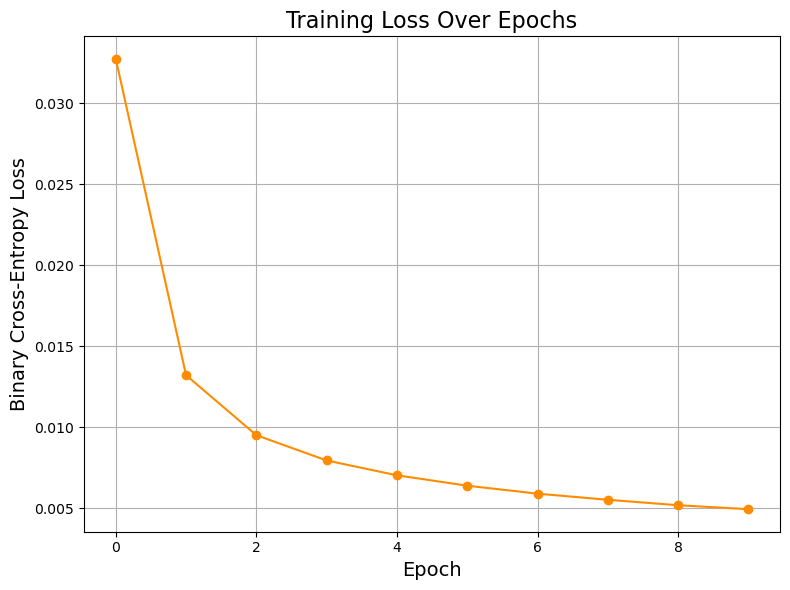

In [53]:
# ---------------------------------------
# 6. Visualize the loss curve
# ---------------------------------------
plt.figure(figsize=(8, 6))
plt.plot(loss_vals, 'o-', color='darkorange')
plt.title("Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Binary Cross-Entropy Loss", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

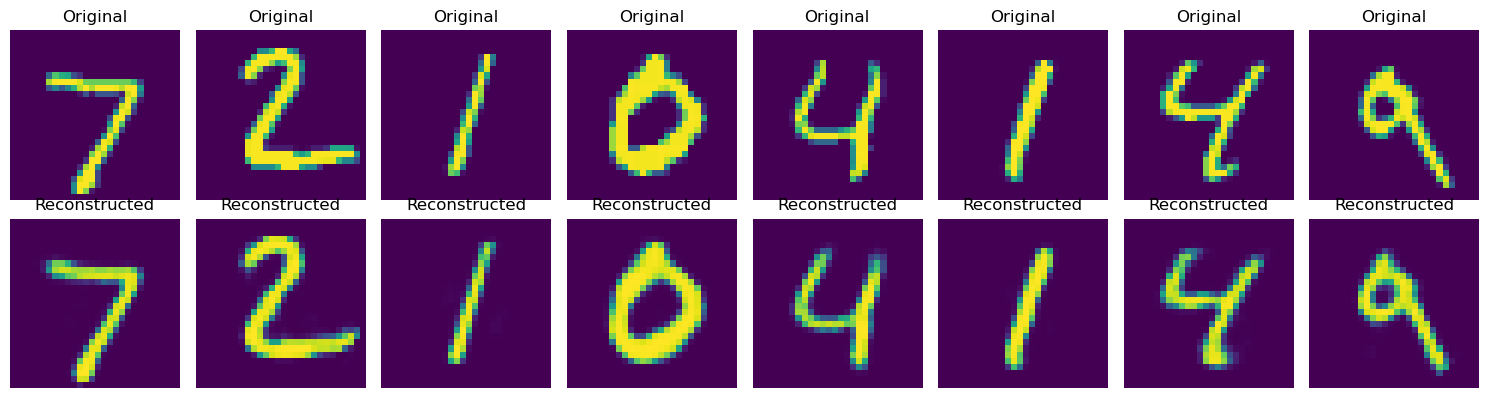

In [54]:
def visualize_reconstructions(model, test_loader, num_images=8):
    """
    Visualize original and reconstructed images
    
    Args:
        model (nn.Module): Trained autoencoder model
        test_loader (DataLoader): Test data loader
        num_images (int): Number of images to visualize
    """
    model.eval()  # Set model to evaluation mode
    
    # Get a batch of test data
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        
        # Get reconstructions
        reconstructed = model(data)
        
        # Move data back to CPU for visualization
        data = data.cpu()
        reconstructed = reconstructed.cpu()
        
        # Create subplots
        fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].squeeze())
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Reconstructed images
            reconstructed_img = reconstructed[i].view(28, 28)
            axes[1, i].imshow(reconstructed_img)
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
visualize_reconstructions(model=model, test_loader=test_loader)

## The question is: Is this a better representation of the data ? Does the latent space captured all unique characteristics of the data ?

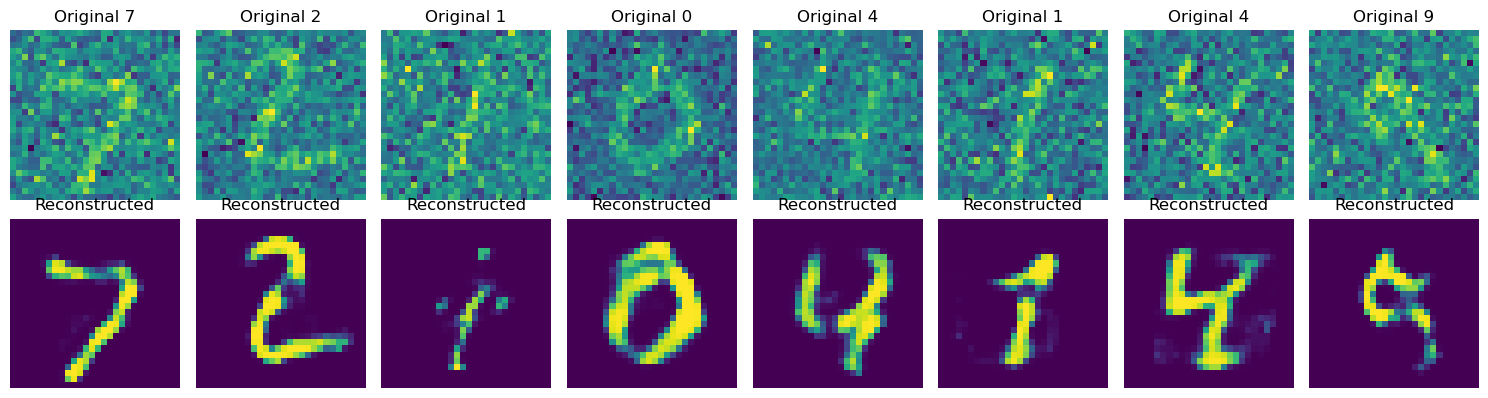

In [55]:
# Let's add some noise
def visualize_reconstructions_with_noise(model, test_loader, num_images=8):
    """
    Visualize original and reconstructed images
    
    Args:
        model (nn.Module): Trained autoencoder model
        test_loader (DataLoader): Test data loader
        num_images (int): Number of images to visualize
    """
    model.eval()  # Set model to evaluation mode
    
    # Get a batch of test data
    with torch.no_grad():
        data, labels = next(iter(test_loader))
        gaus = torch.distributions.Normal(0, 0.5)
        data += gaus.sample(sample_shape=torch.Size(data.shape))       
        data = data.to(device)
        
        labels = labels.cpu().numpy()
        
        # Get reconstructions
        reconstructed = model(data)
        
        # Move data back to CPU for visualization
        data = data.cpu()
        reconstructed = reconstructed.cpu()
        
        # Create subplots
        fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].squeeze())
            axes[0, i].set_title(f'Original {labels[i]}')
            axes[0, i].axis('off')
            
            # Reconstructed images
            reconstructed_img = reconstructed[i].view(28, 28)
            axes[1, i].imshow(reconstructed_img)
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
visualize_reconstructions_with_noise(model=model, test_loader=test_loader)

There is a trick we can play that will allow us to have large latent space and learn a **robust** model. The trick is to create what is called a **denoising autoencoder**